# Heterogeneous Datasets for Federated Survival Analysis Simulation

Example usage of ```uniform_split```, ```quantity_skewed_split```, and ```label_skewed_split```.

First, import a survival dataset. In this example, we use the [METABRIC](https://bmcmedresmethodol.biomedcentral.com/articles/10.1186/s12874-018-0482-1) dataset.

In [1]:
import numpy as np
import pandas as pd

df = pd.read_csv("metabric.csv")
df.head(5)

,x0,x1,x2,x3,x4,x5,x6,x7,x8,time,event
0,5.603834,7.811392,10.797988,5.967607,1.0,1.0,0.0,1.0,56.84,99.333336,0
1,5.284882,9.581043,10.204620,5.664970,1.0,0.0,0.0,1.0,85.94,95.733330,1
2,5.920251,6.776564,12.431715,5.873857,0.0,1.0,0.0,1.0,48.44,140.233340,0
3,6.654017,5.341845,8.646379,5.655888,0.0,0.0,0.0,0.0,66.91,239.300000,0
4,5.456747,5.339741,10.555724,6.008429,1.0,0.0,0.0,1.0,67.85,56.933334,1


Then, extract the ```X```, ```y``` arrays from the dataset. ```X``` has shape ```(n, d)```, where ```n``` is the number of samples in the dataset and ```d```
is the number of features for each sample. ```y``` is a structured array of shape ```(n,)``` and dtype
```[("event", bool), ("time", float)]```, as in [scikit-survival](https://scikit-survival.readthedocs.io/en/stable/index.html#).

In [2]:
X = df[[f"x{i}" for i in range(9)]].to_numpy()
y = np.array([(e, t) for e, t in zip(df["event"], df["time"])], dtype=[("event", bool), ("time", float)])
print(f"X shape: {X.shape}\ny shape {y.shape}")

X shape: (1904, 9)
y shape (1904,)


Finally, apply the data splitting algorithms. To make results reproducible, it is important to set the Numpy seed with ```np.random.seed(<seed_value>)```.

Each splitting algorithm returns a list of ```num_clients``` tuples, each containing an ```X``` array and a ```y``` array.

In ```quantity_skewed_split``` and ```label_skewed_split```, the ```alpha``` > 0 parameter controls the similarity of each client distribution to the original data distribution. For ```alpha``` close to 0, the client distributions differ from the original one. Conversely, for higher values of ```alpha```, the distributions are more uniform.

In [3]:
from federated_survival_datasets import uniform_split, quantity_skewed_split, label_skewed_split

np.random.seed(0)

uniform_client_data = uniform_split(num_clients=8, X=X, y=y)
quantity_skewed_client_data = quantity_skewed_split(num_clients=8, X=X, y=y, alpha=1.8)
label_skewed_client_data = label_skewed_split(num_clients=8, X=X, y=y, alpha=1.8, num_bins=10)

pd.DataFrame({
    "Uniform split data shapes": [f"X: {X_c.shape}, y: {y_c.shape}" for X_c, y_c in uniform_client_data],
    "Quantity-skewed split data shapes": [f"X: {X_c.shape}, y: {y_c.shape}" for X_c, y_c in quantity_skewed_client_data],
    "Label-skewed split data shapes": [f"X: {X_c.shape}, y: {y_c.shape}" for X_c, y_c in label_skewed_client_data]
})

,Uniform split data shapes,Quantity-skewed split data shapes,Label-skewed split data shapes
0,"X: (238, 9), y: (238,)","X: (81, 9), y: (81,)","X: (275, 9), y: (275,)"
1,"X: (238, 9), y: (238,)","X: (374, 9), y: (374,)","X: (261, 9), y: (261,)"
2,"X: (238, 9), y: (238,)","X: (467, 9), y: (467,)","X: (163, 9), y: (163,)"
3,"X: (238, 9), y: (238,)","X: (154, 9), y: (154,)","X: (199, 9), y: (199,)"
4,"X: (238, 9), y: (238,)","X: (230, 9), y: (230,)","X: (370, 9), y: (370,)"
5,"X: (238, 9), y: (238,)","X: (297, 9), y: (297,)","X: (181, 9), y: (181,)"
6,"X: (238, 9), y: (238,)","X: (240, 9), y: (240,)","X: (207, 9), y: (207,)"
7,"X: (238, 9), y: (238,)","X: (61, 9), y: (61,)","X: (248, 9), y: (248,)"


Here, we plot the original Kaplan-Meier estimator alongside the Kaplan-Meier estimators for each client dataset resulting from the three splits.

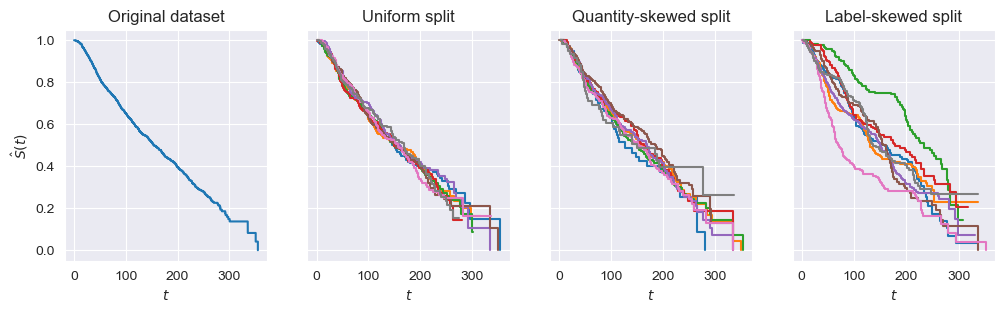

In [4]:
from sksurv.nonparametric import kaplan_meier_estimator
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 4, figsize=(12, 3), sharey=True)
kmx, kmy = kaplan_meier_estimator(y["event"], y["time"])
sns.lineplot(ax=ax[0], x=kmx, y=kmy, drawstyle="steps-post")
ax[0].set_ylabel(r"$\hat{S}(t)$"), ax[0].set_xlabel(r"$t$")

for i, client_data in enumerate([uniform_client_data, quantity_skewed_client_data, label_skewed_client_data]):
    for X_c, y_c in client_data:
        kmx, kmy = kaplan_meier_estimator(y_c["event"], y_c["time"])
        sns.lineplot(ax=ax[i+1], x=kmx, y=kmy, drawstyle="steps-post")
        ax[i+1].set_xlabel(r"$t$")

ax[0].set_title("Original dataset")
ax[1].set_title("Uniform split")
ax[2].set_title("Quantity-skewed split")
ax[3].set_title("Label-skewed split")

plt.show();